# 3/19/20 

In [1]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob
import re

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

/home/petrov/.local/lib/python3.7/site-packages/mplhep/__init__.py:48: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [2]:
from scipy.special import erfc, expit
from iminuit import Minuit
import matplotlib.pyplot as plt

class PhotonEff():
    def __init__(self):
        self.df = None
        self.histos = None
        self.fit_name = None
        self.fit_results = dict()
        self.good_fits = dict()
    def __variance(self, k, n):
        return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2
    def __chi2(self, mu, s, c, N, a):
        xedges, points, errs = self.get_histo_by_name(self.fit_name)
        return np.sum( np.square((points - self.sigFunc(xedges, mu, s, c, N, a))/errs) )
    
    def sigFunc(self, x, mu, s, c, N, a):
        return N*( 1 - expit((x-mu)/s) + c)
#         return N*(c + erfc((x-mu)/s))
    def get_signal_by_name(self, name, x):
        return self.sigFunc( x, *(self.fit_results[name][0]) )
    def get_histo_by_name(self, name):
        xedges = self.histos[name][0]
        points = self.histos[name][1]
        errs = self.histos[name][2]
        return (xedges, points, errs)
    def fit_histo_by_name(self, name):
        self.fit_name = name
        parameters = {
            'mu':0.16,
            's':1/25,
            'c':0.04,
            'N':0.75,
            'a':1,
        }
        limits = {
            'limit_mu' : [0, 1],
            'limit_s' : [0,1],
            'limit_c' : [0,1],
            'limit_N' : [0,1],
            'limit_a' : [0,10],
        }
        errors = {
            'error_mu' : 0.01,
            'error_s' : 1/25,
            'error_c' : 0.01,
            'error_N' : 0.05,
            'error_a' : 0.1,
        }
        m = Minuit( self.__chi2, **parameters, **limits, **errors, errordef=1)
        m.migrad()
        ndf = len(self.get_histo_by_name(name)[0]) - len(m.np_values())
        print(m.migrad_ok())
        self.good_fits[name] = m.migrad_ok()
        return ( m.np_values(), m.np_errors(), m.fval, ndf )
    def show_histo_by_name(self, name):
        xedges, points, errs = self.get_histo_by_name(name)
        plt.errorbar(xedges, points, yerr=errs, fmt='o')
        x = np.linspace(0, xedges.max(), 100)
        text_string = f"name: {name}\n"
        if name in self.fit_results:
            plt.plot(x,  self.sigFunc(x, *(self.fit_results[name][0]) ) )
            chi2, ndf = self.fit_results[name][2], self.fit_results[name][3]
            text_string += f'$\chi^2$/ndf = {chi2:.2f} / {ndf}\n'
#             text_string += f'$\\mu$ = {self.fit_results[name][0][0]}\n'
        plt.text(0.7*xedges.max(), 0.85*points.max(), text_string)
        plt.xlabel('Photon energy, GeV')
        plt.ylabel('Reg efficiency')
        plt.xlim(0, xedges.max())
        return 
    
    def open(self, *files):
        f = [_ for _ in files ]
        it = uproot.pandas.iterate(f, treepath='mc_passed', reportpath=True)
        self.df = pd.concat([j.assign(name=re.findall(r'(\d*.?\d*)_?\d*.root',i)[0]) for i,j in it])
    def get_histo(self, df, bins=81):
        xedges = np.linspace(0, df['ph_energy'].max(), bins)
        hpassed, _ = np.histogram(df.query('passed_cuts==True')['ph_energy'], bins=xedges)
        hall, _ = np.histogram(df['ph_energy'], bins=xedges)
        xedges = (xedges[1:] + xedges[:-1])/2
        points = (hpassed+1)/(hall+2)
        errs = np.sqrt( self.__variance(hpassed, hall) )
        return np.array( [xedges, points, errs] )
    def get_histos(self):
        df = self.df
        self.histos = df.groupby('name').apply(lambda x: self.get_histo(x) )
        return self.histos
    def fit_histos(self):
        for name in self.histos.index:
            self.fit_results[name] = self.fit_histo_by_name(name)
        return
    def get_names(self):
        return self.histos.index

In [3]:
p = PhotonEff()
p.open(*glob('../../outputs/others/trees/*_0.root'))

In [4]:
p.get_histos();

In [5]:
p.fit_histos()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True


In [6]:
p.fit_results;

In [7]:
p.fit_histo_by_name('975.00')

False


(array([0.16288496, 0.04202634, 0.04821631, 0.76015587, 1.        ]),
 array([0., 0., 0., 0., 0.]),
 77.5133277729861,
 75)

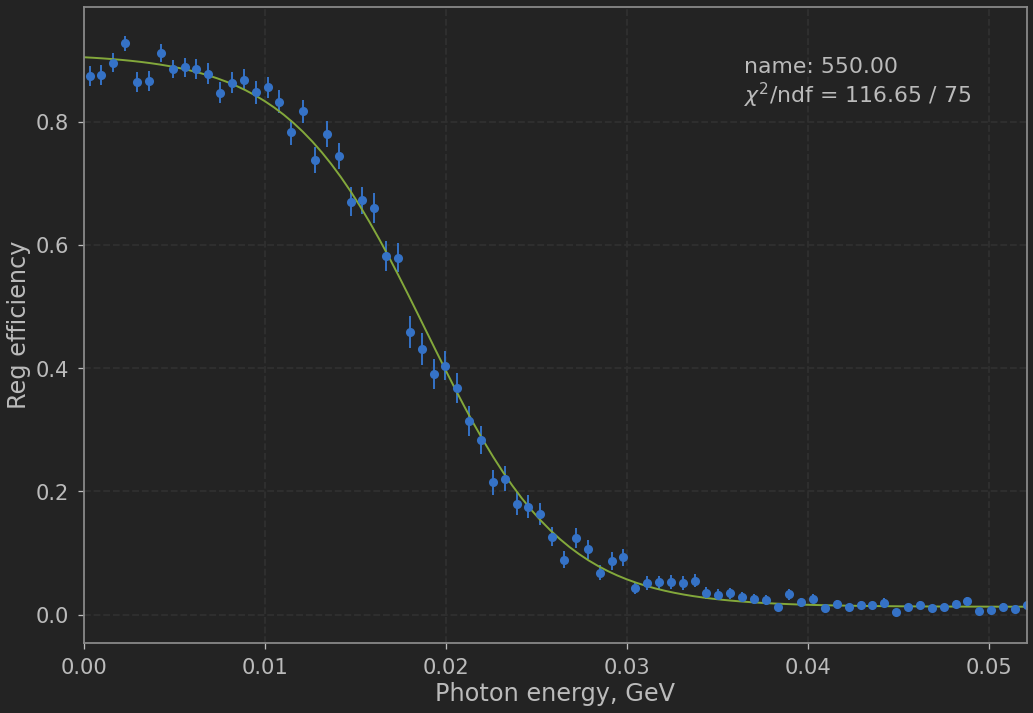

In [8]:
# p.show_histo_by_name('975.00')
p.show_histo_by_name('550.00')

In [13]:
#mu, s, c, N, a
i = 1
chindf_mean = 0
xe = list()
yp = list()
yperr = list()
for e in p.fit_results:
    chindf_mean += p.fit_results[e][2]/p.fit_results[e][3]
    if p.good_fits[e] == False:
        print('Bad fit at', e)
        continue
    xe.append(float(e))
    yp.append(p.fit_results[e][0][i])
    yperr.append(p.fit_results[e][1][i])
print('Chi2/ndf mean:', chindf_mean/len(xe))

Bad fit at 975.00
Chi2/ndf mean: 1.1900420199260107


<ErrorbarContainer object of 3 artists>

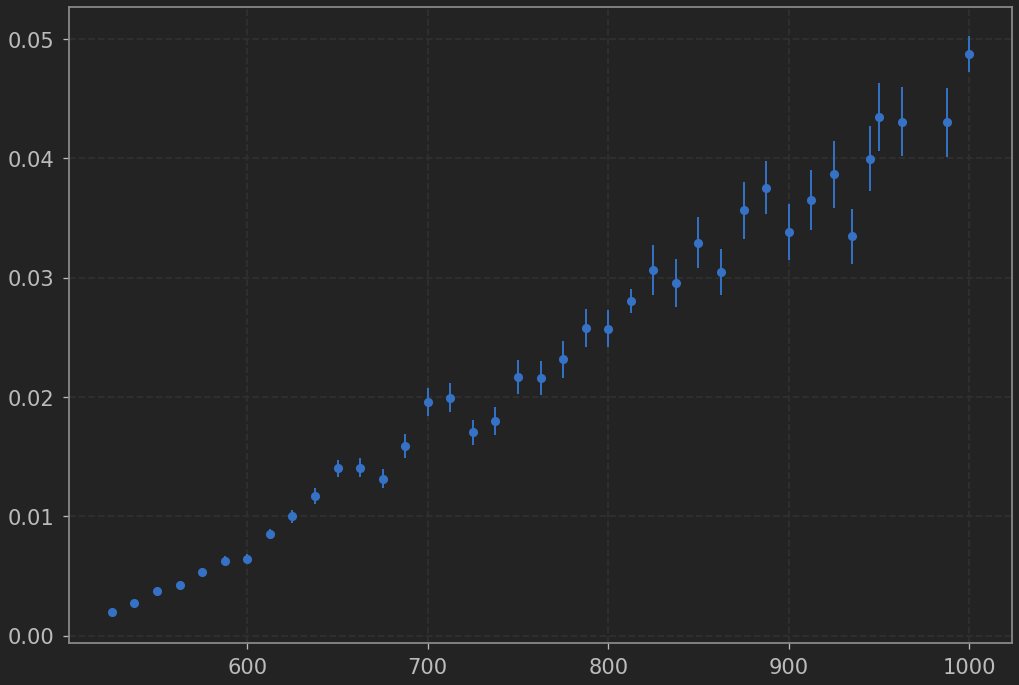

In [14]:
plt.errorbar(xe, yp, yperr, fmt='o')

In [274]:
%ls code

9_radcors.cpp*                      9_radcors_cpp.so*  one_file_handler.py
9_radcors_cpp_ACLiC_dict_rdict.pcm  a.out*             plot_reg_eff_4.py
9_radcors_cpp.d                     cs_klks_cmd2       radcorsnewprog.py


In [15]:
# %load code/radcorsnewprog.py

import scipy.integrate as integrate
import numpy as np

class RadCor:
    alpha = 7.297e-3
    me = 0.511 #MeV
    
    def __init__(self):
        return
    def l(self, E, dE):
        return np.log(E/dE)
    def L(self, s):
        me = self.me
        return np.log(s/(me**2))
    def beta(self, s):
        a = self.alpha
        p = np.pi
        return (2*a/p)*(self.L(s) - 1)
    
    def soft_terms_rad(self, E, dE):
        a = self.alpha
        p = np.pi
        s = 4*(E**2)
        l = self.l(E, dE)
        L = self.L(s)
        
        s1 = -2*l*(L-1) + 3*L/2 + (p**2)/3 - 2
        s2 = (1/2)*((-2*l*(L-1))**2)
        s3 = (3*L/2 + (p**2)/3 - 2)*(-2*l*(L-1))
        s4 = (L**2)*( -l/3 + 11/8 - (p**2)/3 )
        s5 = L*(2*(l**2)/3 + 10*l/9 - 203/48 + 11*(p**2)/12 + 3*1.202)
        s6 = -(4/9)*(l**3) - (10/9)*(l**2) - (2/9)*(28/3 - p**2)*l
        
        result = 1 + (a/p)*s1 + ((a/p)**2)*(s2 + s3 + s4 + s5 + s6)
        return result
    def soft_terms_cs(self, E, cs, dE):
        return self.soft_terms_rad(E, dE)/cs
        
    def F(self, x, s):
        a = self.alpha
        b = self.beta(s)
        p = np.pi
        L = self.L(s)
        m = self.me
        E = np.sqrt(s)/4
        
        s1 = (a/p)*( (p**2)/3 - 1/2 ) + 3*b/4
        s2 = ( (b**2)/24)*(L/3 + 2*(p**2) - 37/4 )
        s3 = -b*(1-x/2)
        s4 = 4*(2-x)*np.log(1/x)
        s5 = (1/x)*(1+3*((1-x)**2))*np.log(1/(1-x))
        s6 = - 6 + x
        
        s7 = 0 if x<(2*m/E) else (1/(6*x))*((x - 2*m/E)**b)*\
            ((np.log(s*(x**2)/(m**2)) - 5/3)**2)*\
            (2 - 2*x + x**2 + (b/3)*(np.log(s*(x**2)/(m**2)) - 5/3))
        s8 = 0 if x<(2*m/E) else ((L**2)/2)*((2/3)*((1-(1-x)**3)/(1-x)) -\
            (2-x)*np.log(1/(1-x)) + x/2 )
        
        
        result = b*(x**(b-1))*( 1 + s1 + s2 ) + s3 + \
        (1/8)*(b**2)*(s4 + s5 + s6) + \
        ((a/p)**2)*(s7 + s8)
        return result
    
    def F_Integral(self, e, cs, e_beam, params, Xmax=1):
        s = 4*(e_beam**2)
        s_cs = 4*(e**2)
        if not( np.all(np.diff(s_cs) > 0) ):
            print('Problem')
        return integrate.quad( lambda x: self.F(x, s)*np.interp(s*(1-x), s_cs, cs)*sigFunc(np.sqrt(s/4)*x*1e-3, *params), 
                              0., Xmax, points=[0, 1], 
                              limit=1000, epsrel=0.001)#epsabs=1e-3)
    def F_Radcor(self, e, cs, e_beam, params, Xmax=1):
        integral = self.F_Integral( e, cs, e_beam, params, Xmax)
        return ( integral[0]/np.interp(e_beam, e, cs), integral[1]/np.interp(e_beam, e, cs) )

def sigFunc(x, mu, sig, c, N, a):
        return N*( 1 - expit((x-mu)/sig) + c)

In [16]:
with open('code/cs_klks_cmd2') as f:
    txt = f.readlines()
e = np.array( list(map(lambda x: float(x.split(' ')[1])/2, txt) ) )
cs = np.array( list(map(lambda x: float(x.split(' ')[2]), txt) ) )

In [17]:
r = RadCor()

In [18]:
r.F_Radcor(e, cs, 800, p.fit_results['800.00'][0], 1)

(0.7739480755599113, 0.00015514944722066473)

In [19]:
xen = list()
xrad = list()
for en in p.fit_results:
    ps = p.fit_results[en][0]
    res = r.F_Radcor(e, cs, float(en), ps, 1) 
    print( 'Energy:', en, 'Rad:', res[0])
    xen.append(float(en))
    xrad.append(res[0])

Energy: 1000.00 Rad: 1.0311738905137326
Energy: 525.00 Rad: 0.7683564357330358
Energy: 537.50 Rad: 0.7841318478602325
Energy: 550.00 Rad: 0.8070941978441879
Energy: 562.50 Rad: 0.8225600310088013
Energy: 575.00 Rad: 0.8480207003076775
Energy: 587.50 Rad: 0.853323499868912
Energy: 600.00 Rad: 0.8805427071617791
Energy: 612.50 Rad: 0.8975015082039683
Energy: 625.00 Rad: 0.907008091912954
Energy: 637.50 Rad: 0.8886125593608571
Energy: 650.00 Rad: 0.9639524276631819
Energy: 662.50 Rad: 0.940436136093597
Energy: 675.00 Rad: 0.9618772661581612
Energy: 687.50 Rad: 0.94660235705735
Energy: 700.00 Rad: 0.9375988169887247
Energy: 712.50 Rad: 0.8938773881181813
Energy: 725.00 Rad: 0.9163942443086445
Energy: 737.50 Rad: 0.8823446668384954
Energy: 750.00 Rad: 0.8394583167109236
Energy: 762.50 Rad: 0.8658915695515867
Energy: 775.00 Rad: 0.8436276471439123
Energy: 787.50 Rad: 0.7861265791594092
Energy: 800.00 Rad: 0.7739480755599113
Energy: 812.50 Rad: 0.7621539433988435
Energy: 825.00 Rad: 0.7629534

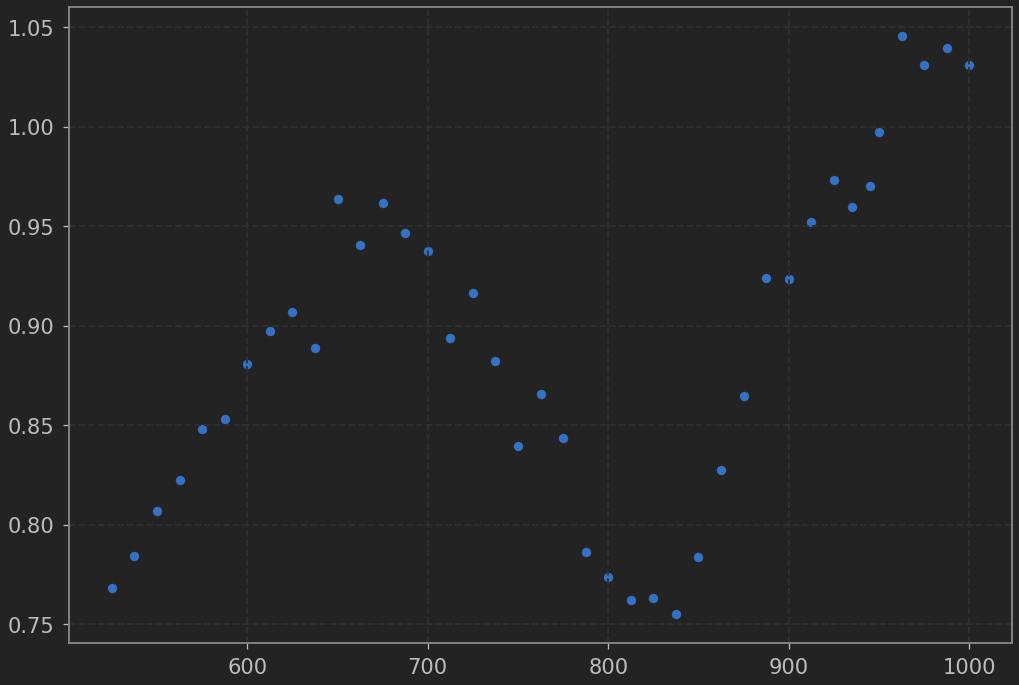

In [20]:
plt.scatter(xen, np.array(xrad) )
# plt.plot(e[40:], cs[40:])
# plt.yscale('log')